# Assignment 3: 

[Available on Google Colaboratory](https://colab.research.google.com/drive/1QrcjfdcahcBPU3FuKMhxMGozGRzMTA3H)

## About

In this assignment, you will work with the daily weather data for the city of Madrid from 1997 - 2015.

The objective is to train a neural network that will predict various weather events including:

- Rain
- Snow
- Fog
- Thunderstorm
- Hail
- Tornado

## Submission: December 8, 11:59PM

> - You must submit via `git push`.
> - You must complete running all the cells, and include the executed Jupyter notebook in the submitted commit.
> - **Due Date**: **December 8, 11:59PM**
> - No late submission can be accepted.
> - No exceptions for submission date is possible due to the end of semester.

In [0]:
%tensorflow_version 2.x

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Reshape, Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.losses import sparse_categorical_crossentropy
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
np.set_printoptions(suppress=True, precision=2)

# Getting the data

The data is available at the given URL.  The following code will load the data into a [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/).

If you are unfamiliar with DataFrame API, you can easily pick it up from here: https://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html

Very minimal knowledge of DataFrame is needed, as most of the code is provided in the notebook already.

In [0]:
url = 'https://github.com/ontariotechu-csci4050u/course-material-2019/' \
      'raw/master/data/weather_madrid_LEMD_1997_2015.csv.gz'
df = pd.read_csv(url).rename(columns={"CET": "date"}).set_index('date')
df.columns = [x.strip() for x in df.columns]

This is what the dataframe `df` looks like.  Note that it has a number of numerical attributes including _temperature_, _pressure_, _visibility_, etc.

In [654]:
print(df)

            Max TemperatureC  Mean TemperatureC  ...     Events  WindDirDegrees
date                                             ...                           
1997-1-1                 7.0                4.0  ...        NaN             229
1997-1-2                 7.0                3.0  ...       Rain             143
1997-1-3                 5.0                3.0  ...  Rain-Snow             256
1997-1-4                 7.0                3.0  ...        NaN             284
1997-1-5                 2.0                0.0  ...       Snow               2
...                      ...                ...  ...        ...             ...
2015-12-27              14.0                7.0  ...        Fog              38
2015-12-28              15.0                8.0  ...       Rain             243
2015-12-29              11.0                8.0  ...   Fog-Rain             190
2015-12-30               9.0                8.0  ...        NaN             256
2015-12-31              12.0            

# Building the weather event columns

We construct _binary_ columns as indicators of the key weather events that occurred during the day.

The weather conditions are:

- Rain, Snow, Fog, Thunderstorm, Hail, Tornado
- and also _NoEvent_.

They are additional columns to the dataframe.

In [0]:
event_columns = ['Rain', 'Snow', 'Fog', 'Thunderstorm', 'Hail', 'Tornado', 'NoEvent']

In [0]:
for ev in event_columns:
  if ev == 'NoEvent':
    df[ev] = df['Events'].isna()
  else:
    df[ev] = df['Events'].str.contains(ev).fillna(False)

In [0]:
#temp = df.get('Tornado')
    

In [657]:
print(temp)

date
1997-1-2      False
1997-1-9      False
1997-2-15     False
1997-4-17     False
1997-5-5      False
              ...  
2015-11-4     False
2015-11-5     False
2015-12-14    False
2015-12-28    False
2015-12-29    False
Name: Tornado, Length: 998, dtype: bool


Here is the _augmented_ dataframe.  Scroll horizontally to make sure that `df` now contains the binary indicators of each weather event.

In [0]:
df = df.fillna(0)
#df.head()

In [0]:
tor = df.loc[df.loc[:,'Tornado'] == True]
ha = df.loc[df.loc[:,'Hail'] == True]
df = df.append([tor]*10,ignore_index=True)
df = df.append([ha]*5,ignore_index=True)

## Building the features

We identify the numeric columns as _observations_.  We will use these columns as input vectors to a neural network.

**Note**: Since large magnitude differences will cause serious numerical issues during gradient descent, we *always* use **normalized** vectors.  So for each numerical column, we compute the minimum and maximum values which are used to rescale the column to the range of :
`[0.0 .. 1.0]`

In [0]:
def get_normalized_features(df, columns):
  df2 = pd.DataFrame(index=df.index)
  for c in columns:
    series = df[c]
    max = series.max()
    min = series.min()
    df2[c] = (series - min) / (max - min)
  return df2

In [0]:
numeric_columns = [
       'Max TemperatureC',
       'Mean TemperatureC',
       'Min TemperatureC',
       'Dew PointC',
       'MeanDew PointC',
       'Min DewpointC',
       'Max Humidity',
       'Mean Humidity',
       'Min Humidity',
       'Max Sea Level PressurehPa',
       'Mean Sea Level PressurehPa',
       'Min Sea Level PressurehPa',
       'Max VisibilityKm',
       'Mean VisibilityKm',
       'Min VisibilitykM',
       'Max Wind SpeedKm/h',
       'Mean Wind SpeedKm/h',
       'Max Gust SpeedKm/h',
       'Precipitationmm',
       'CloudCover',
       'WindDirDegrees']

The features are the normalized observations.  We can use them in learning a model to predict weather events.

In [662]:
features = get_normalized_features(df, numeric_columns)
features.head()

,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,WindDirDegrees
0,0.170732,0.200000,0.315789,0.53125,0.580645,0.666667,1.00,0.95,0.76,0.301887,0.385965,0.513158,0.322581,0.290323,0.129032,0.071429,0.153846,0.000000,0.0,0.750,0.637119
1,0.170732,0.171429,0.263158,0.56250,0.580645,0.611111,1.00,0.92,0.71,0.245283,0.298246,0.421053,0.322581,0.290323,0.129032,0.142857,0.205128,0.456311,0.0,0.625,0.398892
2,0.121951,0.171429,0.315789,0.53125,0.516129,0.583333,1.00,0.85,0.70,0.207547,0.228070,0.407895,0.322581,0.322581,0.225806,0.148352,0.487179,0.000000,0.0,0.750,0.711911
3,0.170732,0.171429,0.236842,0.31250,0.387097,0.500000,0.86,0.63,0.49,0.339623,0.421053,0.526316,0.322581,0.322581,0.322581,0.148352,0.487179,0.388350,0.0,0.250,0.789474
4,0.048780,0.085714,0.236842,0.43750,0.483871,0.527778,1.00,0.95,0.86,0.339623,0.385965,0.526316,0.322581,0.161290,0.032258,0.076923,0.153846,0.000000,0.0,0.875,0.008310


In [663]:
features = features.sort_index()
features.shape

(6862, 21)

# Building Output

The targets are 0/1 columns for each of the 

In [664]:
targets = df[event_columns].applymap(lambda x: 1 if x else 0)
targets.head(), targets.sum()

(   Rain  Snow  Fog  Thunderstorm  Hail  Tornado  NoEvent
 0     0     0    0             0     0        0        1
 1     1     0    0             0     0        0        0
 2     1     1    0             0     0        0        0
 3     0     0    0             0     0        0        1
 4     0     1    0             0     0        0        0, Rain            1540
 Snow              53
 Fog              309
 Thunderstorm     337
 Hail              48
 Tornado           11
 NoEvent         5014
 dtype: int64)

# Building the training and test data

We will split the data as follows:

- Training: 1997 - 2007
- Testing: 2007 - 2015

In [665]:
x_train = features.loc[:'2007-12-31']
x_test = features.loc['2008-1-1':]

y_train = targets.loc[x_train.index]
y_test = targets.loc[x_test.index]
y_train.sum()

Rain             434
Snow              10
Fog              103
Thunderstorm     110
Hail               2
Tornado            1
NoEvent         1468
dtype: int64

In [666]:
y_train_rain = y_train['Rain']
y_train_snow = y_train['Snow']
y_train_fog = y_train['Fog']
y_train_thunder = y_train['Thunderstorm']
y_train_hail = y_train['Hail']
y_train_tornado = y_train['Tornado']
y_test_rain = y_test['Rain']
y_test_snow = y_test['Snow']
y_test_fog = y_test['Fog']
y_test_thunder = y_test['Thunderstorm']
y_test_hail = y_test['Hail']
y_test_tornado = y_test['Tornado']
y_train.head(20)


,Rain,Snow,Fog,Thunderstorm,Hail,Tornado,NoEvent
0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0
2,1,1,0,0,0,0,0
3,0,0,0,0,0,0,1
4,0,1,0,0,0,0,0
5,0,0,0,0,0,0,1
6,0,1,0,0,0,0,0
7,1,0,0,0,0,0,0
8,1,0,0,0,0,0,0
9,0,0,0,0,0,0,1


In [667]:

x_train = x_train.values
x_test = x_test.values
y_train_rain = y_train_rain.values
y_train_snow = y_train_snow.values
y_train_fog = y_train_fog.values
y_train_thunder = y_train_thunder.values
y_train_hail = y_train_hail.values
y_train_tornado = y_train_tornado.values
y_test_rain = y_test_rain.values
y_test_snow = y_test_snow.values
y_test_fog = y_test_fog.values
y_test_thunder = y_test_thunder.values
y_test_hail = y_test_hail.values
y_test_tornado = y_test_tornado.values
type(x_train)

numpy.ndarray

In [668]:
x_train.shape, y_train_rain.shape

((2008, 21), (2008,))

In [669]:
y_train.sum()

Rain             434
Snow              10
Fog              103
Thunderstorm     110
Hail               2
Tornado            1
NoEvent         1468
dtype: int64

In [670]:
#y_train_rain = to_categorical(y_train_rain)
y_train_rain[0:5]

array([0, 1, 1, 0, 0])

In [671]:
n_cols = x_train.shape[1]
y_train_rain.shape

(2008,)

# ✎ Build model(s)

You need to build a _Keras_ model that predicts the weather events.

The only restriction is that you must **NOT** use the dataframes `x_test`, `y_test` during training.

**Note**:

You can build one or more models (for example, one model for each and different weather event).

You need to design the architecture and the loss function.

In [672]:

model = Sequential([
    Input((21,)),
    Flatten(),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'), 
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')                   
])
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer= opt,
    loss = 'binary_crossentropy',
    metrics = ['accuracy'])
model.summary()

Model: "sequential_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_78 (Flatten)         (None, 21)                0         
_________________________________________________________________
dense_312 (Dense)            (None, 10)                220       
_________________________________________________________________
dense_313 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_314 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_315 (Dense)            (None, 1)                 11        
Total params: 451
Trainable params: 451
Non-trainable params: 0
_________________________________________________________________


In [673]:
model2 = Sequential([
    Input((21,)),
    Flatten(),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'), 
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')                   
])
model2.compile(optimizer= opt,
    loss = 'binary_crossentropy',
    metrics = ['accuracy'])
model2.summary()

Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_79 (Flatten)         (None, 21)                0         
_________________________________________________________________
dense_316 (Dense)            (None, 10)                220       
_________________________________________________________________
dense_317 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_318 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_319 (Dense)            (None, 1)                 11        
Total params: 451
Trainable params: 451
Non-trainable params: 0
_________________________________________________________________


In [674]:
model3 = Sequential([
    Input((21,)),
    Flatten(),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'), 
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')                   
])
model3.compile(optimizer= opt,
    loss = 'binary_crossentropy',
    metrics = ['accuracy'])
model3.summary()

Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_80 (Flatten)         (None, 21)                0         
_________________________________________________________________
dense_320 (Dense)            (None, 10)                220       
_________________________________________________________________
dense_321 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_322 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_323 (Dense)            (None, 1)                 11        
Total params: 451
Trainable params: 451
Non-trainable params: 0
_________________________________________________________________


In [675]:
model4 = Sequential([
    Input((21,)),
    Flatten(),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'), 
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')                   
])
model4.compile(optimizer= opt,
    loss = 'binary_crossentropy',
    metrics = ['accuracy'])
model4.summary()

Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_81 (Flatten)         (None, 21)                0         
_________________________________________________________________
dense_324 (Dense)            (None, 10)                220       
_________________________________________________________________
dense_325 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_326 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_327 (Dense)            (None, 1)                 11        
Total params: 451
Trainable params: 451
Non-trainable params: 0
_________________________________________________________________


In [676]:
model5 = Sequential([
    Input((21,)),
    Flatten(),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'), 
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')                   
])
model5.compile(optimizer= opt,
    loss = 'binary_crossentropy',
    metrics = ['accuracy'])
model5.summary()

Model: "sequential_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_82 (Flatten)         (None, 21)                0         
_________________________________________________________________
dense_328 (Dense)            (None, 10)                220       
_________________________________________________________________
dense_329 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_330 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_331 (Dense)            (None, 1)                 11        
Total params: 451
Trainable params: 451
Non-trainable params: 0
_________________________________________________________________


In [677]:
model6 = Sequential([
    Input((21,)),
    Flatten(),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'), 
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')                   
])

model6.compile(optimizer= opt,
    loss = 'binary_crossentropy',
    metrics = ['accuracy'])
model6.summary()

Model: "sequential_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_83 (Flatten)         (None, 21)                0         
_________________________________________________________________
dense_332 (Dense)            (None, 10)                220       
_________________________________________________________________
dense_333 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_334 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_335 (Dense)            (None, 1)                 11        
Total params: 451
Trainable params: 451
Non-trainable params: 0
_________________________________________________________________


# ✎ Train the model(s)

You must:

- Select an appropriate optimizer and learning rate.
- Plot the loss over the epochs of training.
- Plot the training accuracy over the epochs.

**Challenge**

It's extremely difficult to get good training on _rare_ events.  Note that there is only **ONE** Tornado and **TWO** Hail events in the training data.

An effective way is to duplicate the rare events in the training data, and use _shuffle=True_ in the training (model.fit) so that the network sees approximately equal number of occurrances of different weather events.

In [678]:
# train your models

history = model.fit(
    x_train,
    y_train_rain, 
    validation_split = 0.1,
    shuffle = True,
    epochs = 100, 
    batch_size = 128

)

Train on 1807 samples, validate on 201 samples
Epoch 1/100
1807/1807 [==============================] - 1s 361us/sample - loss: 0.5380 - accuracy: 0.7615 - val_loss: 0.4027 - val_accuracy: 0.8259
Epoch 2/100
1807/1807 [==============================] - 0s 28us/sample - loss: 0.4307 - accuracy: 0.7792 - val_loss: 0.3126 - val_accuracy: 0.8259
Epoch 3/100
1807/1807 [==============================] - 0s 29us/sample - loss: 0.3582 - accuracy: 0.8019 - val_loss: 0.2550 - val_accuracy: 0.8905
Epoch 4/100
1807/1807 [==============================] - 0s 25us/sample - loss: 0.3226 - accuracy: 0.8478 - val_loss: 0.2215 - val_accuracy: 0.8856
Epoch 5/100
1807/1807 [==============================] - 0s 27us/sample - loss: 0.2947 - accuracy: 0.8749 - val_loss: 0.3224 - val_accuracy: 0.8557
Epoch 6/100
1807/1807 [==============================] - 0s 30us/sample - loss: 0.3315 - accuracy: 0.8473 - val_loss: 0.2171 - val_accuracy: 0.8856
Epoch 7/100
1807/1807 [==============================] - 0s 29us

In [679]:
history2 = model2.fit(
    x_train,
    y_train_snow, 
    validation_split = 0.1,
    shuffle = True,
    epochs = 100, 
    batch_size = 128

)

Train on 1807 samples, validate on 201 samples
Epoch 1/100
1807/1807 [==============================] - 1s 352us/sample - loss: 0.2417 - accuracy: 0.9308 - val_loss: 1.6276e-11 - val_accuracy: 1.0000
Epoch 2/100
1807/1807 [==============================] - 0s 30us/sample - loss: 0.0571 - accuracy: 0.9945 - val_loss: 0.0403 - val_accuracy: 1.0000
Epoch 3/100
1807/1807 [==============================] - 0s 29us/sample - loss: 0.0369 - accuracy: 0.9945 - val_loss: 7.6911e-04 - val_accuracy: 1.0000
Epoch 4/100
1807/1807 [==============================] - 0s 26us/sample - loss: 0.0316 - accuracy: 0.9945 - val_loss: 9.9917e-04 - val_accuracy: 1.0000
Epoch 5/100
1807/1807 [==============================] - 0s 27us/sample - loss: 0.0271 - accuracy: 0.9945 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 6/100
1807/1807 [==============================] - 0s 30us/sample - loss: 0.0268 - accuracy: 0.9945 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 7/100
1807/1807 [=============================

In [680]:
history3 = model3.fit(
    x_train,
    y_train_fog, 
    validation_split = 0.1,
    shuffle = True,
    epochs = 100, 
    batch_size = 128

)

Train on 1807 samples, validate on 201 samples
Epoch 1/100
1807/1807 [==============================] - 1s 362us/sample - loss: 0.3457 - accuracy: 0.9065 - val_loss: 0.1455 - val_accuracy: 0.9900
Epoch 2/100
1807/1807 [==============================] - 0s 33us/sample - loss: 0.1924 - accuracy: 0.9441 - val_loss: 0.0507 - val_accuracy: 0.9900
Epoch 3/100
1807/1807 [==============================] - 0s 28us/sample - loss: 0.1634 - accuracy: 0.9441 - val_loss: 0.0412 - val_accuracy: 0.9900
Epoch 4/100
1807/1807 [==============================] - 0s 27us/sample - loss: 0.1468 - accuracy: 0.9441 - val_loss: 0.0373 - val_accuracy: 0.9900
Epoch 5/100
1807/1807 [==============================] - 0s 27us/sample - loss: 0.1321 - accuracy: 0.9441 - val_loss: 0.0361 - val_accuracy: 0.9900
Epoch 6/100
1807/1807 [==============================] - 0s 28us/sample - loss: 0.1260 - accuracy: 0.9441 - val_loss: 0.0286 - val_accuracy: 0.9900
Epoch 7/100
1807/1807 [==============================] - 0s 28us

In [681]:
history4 = model4.fit(
    x_train,
    y_train_thunder, 
    validation_split = 0.1,
    shuffle = True,
    epochs = 100, 
    batch_size = 128

)

Train on 1807 samples, validate on 201 samples
Epoch 1/100
1807/1807 [==============================] - 1s 360us/sample - loss: 0.3068 - accuracy: 0.9336 - val_loss: 0.1777 - val_accuracy: 0.9602
Epoch 2/100
1807/1807 [==============================] - 0s 28us/sample - loss: 0.2278 - accuracy: 0.9436 - val_loss: 0.1808 - val_accuracy: 0.9602
Epoch 3/100
1807/1807 [==============================] - 0s 30us/sample - loss: 0.2084 - accuracy: 0.9436 - val_loss: 0.1671 - val_accuracy: 0.9602
Epoch 4/100
1807/1807 [==============================] - 0s 27us/sample - loss: 0.1858 - accuracy: 0.9436 - val_loss: 0.1971 - val_accuracy: 0.9602
Epoch 5/100
1807/1807 [==============================] - 0s 30us/sample - loss: 0.1728 - accuracy: 0.9436 - val_loss: 0.1669 - val_accuracy: 0.9602
Epoch 6/100
1807/1807 [==============================] - 0s 26us/sample - loss: 0.1629 - accuracy: 0.9436 - val_loss: 0.1788 - val_accuracy: 0.9602
Epoch 7/100
1807/1807 [==============================] - 0s 26us

In [682]:
history5 = model5.fit(
    x_train,
    y_train_hail, 
    validation_split = 0.1,
    shuffle = True,
    epochs = 100, 
    batch_size = 128

)

Train on 1807 samples, validate on 201 samples
Epoch 1/100
1807/1807 [==============================] - 1s 360us/sample - loss: 0.1461 - accuracy: 0.9308 - val_loss: 3.2046e-18 - val_accuracy: 1.0000
Epoch 2/100
1807/1807 [==============================] - 0s 26us/sample - loss: 0.0686 - accuracy: 0.9989 - val_loss: 5.7230e-13 - val_accuracy: 1.0000
Epoch 3/100
1807/1807 [==============================] - 0s 25us/sample - loss: 0.0274 - accuracy: 0.9989 - val_loss: 1.4761e-07 - val_accuracy: 1.0000
Epoch 4/100
1807/1807 [==============================] - 0s 30us/sample - loss: 0.0143 - accuracy: 0.9989 - val_loss: 2.5655e-04 - val_accuracy: 1.0000
Epoch 5/100
1807/1807 [==============================] - 0s 25us/sample - loss: 0.0082 - accuracy: 0.9989 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 6/100
1807/1807 [==============================] - 0s 32us/sample - loss: 0.0084 - accuracy: 0.9989 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 7/100
1807/1807 [=========================

In [683]:
history6 = model6.fit(
    x_train,
    y_train_tornado, 
    validation_split = 0.1,
    shuffle = True,
    epochs = 100, 
    batch_size = 128

)

Train on 1807 samples, validate on 201 samples
Epoch 1/100
1807/1807 [==============================] - 1s 359us/sample - loss: 0.0963 - accuracy: 0.9884 - val_loss: 1.7233e-16 - val_accuracy: 1.0000
Epoch 2/100
1807/1807 [==============================] - 0s 31us/sample - loss: 0.0259 - accuracy: 0.9994 - val_loss: 9.6126e-11 - val_accuracy: 1.0000
Epoch 3/100
1807/1807 [==============================] - 0s 28us/sample - loss: 0.0127 - accuracy: 0.9994 - val_loss: 5.0305e-08 - val_accuracy: 1.0000
Epoch 4/100
1807/1807 [==============================] - 0s 29us/sample - loss: 0.0081 - accuracy: 0.9994 - val_loss: 5.3771e-05 - val_accuracy: 1.0000
Epoch 5/100
1807/1807 [==============================] - 0s 27us/sample - loss: 0.0049 - accuracy: 0.9994 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 6/100
1807/1807 [==============================] - 0s 28us/sample - loss: 0.0049 - accuracy: 0.9994 - val_loss: 2.0910e-04 - val_accuracy: 1.0000
Epoch 7/100
1807/1807 [=====================

# ✎ Evaluation

Evaluate the model using the test data.

- You must plot the test accurarcy with respect to **each** event type.

- For which weather event is your model actually useful?


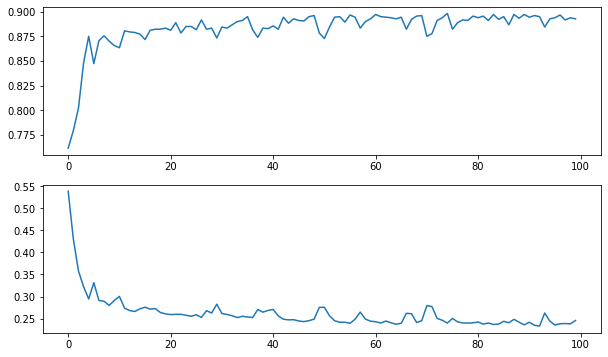

In [684]:
#
pl.figure(figsize=(10, 6))
pl.subplot(2,1,1)
pl.plot(history.history['accuracy']);


pl.subplot(2,1,2)
pl.plot(history.history['loss']);


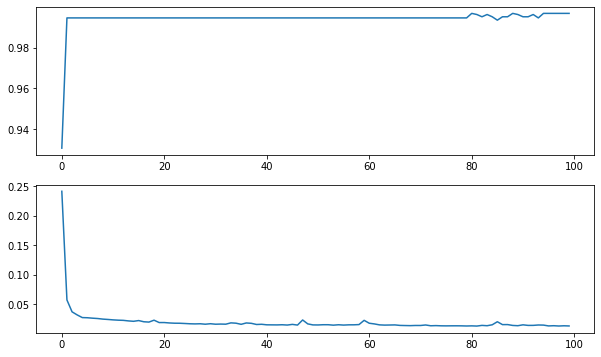

In [685]:
#
pl.figure(figsize=(10, 6))
pl.subplot(2,1,1)
pl.plot(history2.history['accuracy']);


pl.subplot(2,1,2)
pl.plot(history2.history['loss']);

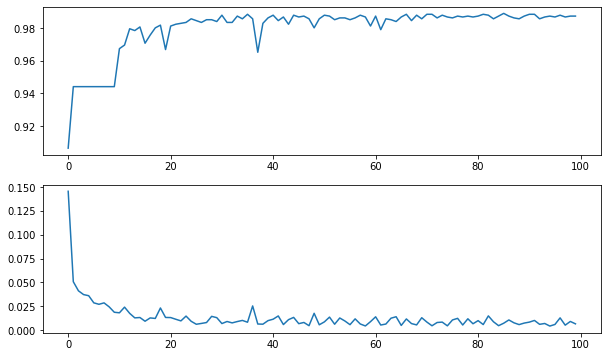

In [686]:
#
pl.figure(figsize=(10, 6))
pl.subplot(2,1,1)
pl.plot(history3.history['accuracy']);


pl.subplot(2,1,2)
pl.plot(history3.history['val_loss']);

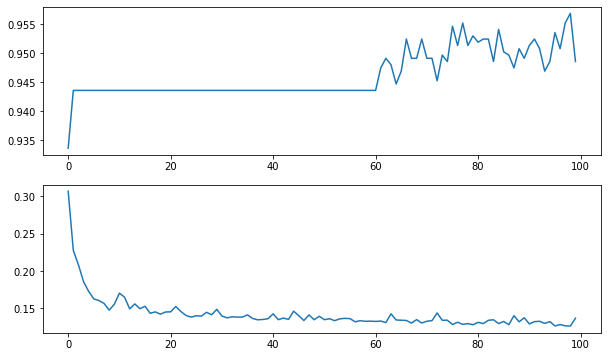

In [687]:
#
pl.figure(figsize=(10, 6))
pl.subplot(2,1,1)
pl.plot(history4.history['accuracy']);


pl.subplot(2,1,2)
pl.plot(history4.history['loss']);

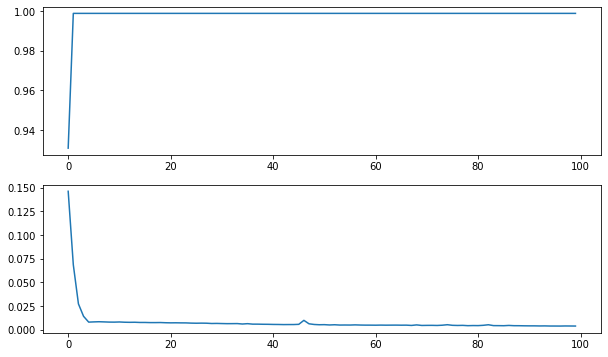

In [688]:
#
pl.figure(figsize=(10, 6))
pl.subplot(2,1,1)
pl.plot(history5.history['accuracy']);


pl.subplot(2,1,2)
pl.plot(history5.history['loss']);

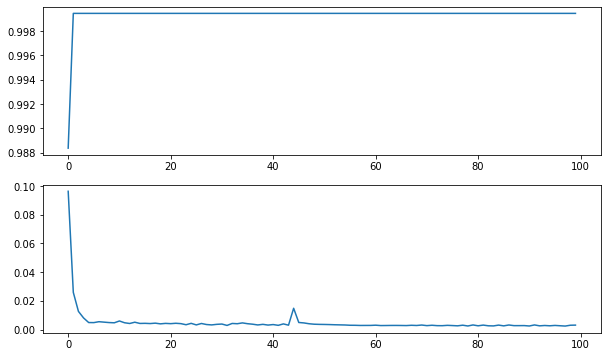

In [689]:
#
pl.figure(figsize=(10, 6))
pl.subplot(2,1,1)
pl.plot(history6.history['accuracy']);


pl.subplot(2,1,2)
pl.plot(history6.history['loss']);

In [690]:
x_test.shape , y_test.head

((4853, 21),
 <bound method NDFrame.head of       Rain  Snow  Fog  Thunderstorm  Hail  Tornado  NoEvent
 2009     1     0    0             1     0        0        0
 2010     1     0    0             0     0        0        0
 2011     1     0    0             0     0        0        0
 2012     0     0    0             0     0        0        1
 2013     0     0    0             0     0        0        1
 ...    ...   ...  ...           ...   ...      ...      ...
 6857     1     0    0             1     1        0        0
 6858     1     0    0             1     1        0        0
 6859     1     0    0             1     1        0        0
 6860     1     0    0             1     1        0        0
 6861     1     0    0             0     1        0        0
 
 [4853 rows x 7 columns]>)

In [691]:
acc_test2 = model.evaluate(
  x_test,
  y_test_rain
)
acc_test2

4853/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.25709185349973185, 0.88563776]

In [692]:
acc_test3 = model2.evaluate(
  x_test,
  y_test_snow
)
acc_test3

4853/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.025556992349806518, 0.9913456]

In [693]:
acc_test4 = model3.evaluate(
  x_test,
  y_test_fog
)
acc_test4

4853/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.10913933867083352, 0.95734596]

In [694]:
acc_test5 = model4.evaluate(
  x_test,
  y_test_thunder
)
acc_test5

4853/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.1557012863761183, 0.93674016]

In [695]:
acc_test6 = model5.evaluate(
  x_test,
  y_test_hail
)
acc_test6

4853/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.053067817322187016, 0.9905213]

In [696]:
acc_test7 = model6.evaluate(
  x_test,
  y_test_tornado
)
model.metrics_names
acc_test7

4853/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.007909311583959716, 0.9979394]

In [697]:
predictions = model.predict(x_test[:20])
predictions = np.transpose(predictions)
print (np.around(predictions))
print (y_test_rain[:20])

[[1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0.]]
[1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0]


The event that this model is actually useful for is the rain event.  Since this was the most common event that occured in the dataset the model had enough training data to correct the weights.  